In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Sequential
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
df_train = pd.read_csv("./input/train.csv")
df_test = pd.read_csv("./input/test.csv")
print("Train shape : ",df_train.shape)
print("Test shape : ",df_test.shape)

df_train_pos = df_train[df_train['target']==1]
df_train_neg = df_train[df_train['target']==0].sample(len(df_train_pos)*2,random_state=1)
df_train = pd.concat([df_train_pos,df_train_neg])
df_train = df_train.sample(frac=1,random_state=1)
print("Train shape : ",df_train.shape)

## fill up the missing values
# train_X_raw = df_train["question_text"].fillna("_##_").values
# test_X_raw = df_test["question_text"].fillna("_##_").values

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

char_dict = {chr(i+96):i for i in range(1,27)}
char_dict[' '] = 0 
vocab_size = len(char_dict)

train_X_filt = []
train_Y = []
for i in range(len(df_train)):
    s=[]
    for char in df_train.iloc[i]['question_text'].lower():
        if char in char_dict.keys():
            s.append(char_dict[char])
    if s!=[]:
        train_X_filt.append(s)
        train_Y.append(df_train.iloc[i]['target'])
    else:
        print(df_train.iloc[i])
train_Y = np.asarray(train_Y)
        
test_X_filt = []
for sent in df_test["question_text"].values:
    s=[]
    for char in sent.lower():
        if char in char_dict.keys():
            s.append(char_dict[char])
    test_X_filt.append(s) 

Train shape :  (1306122, 3)
Test shape :  (56370, 2)
Train shape :  (242430, 3)
qid              527aac2ce6f12f789fe5
question_text                       "
target                              1
Name: 420816, dtype: object


In [4]:

df_train.iloc[0]['question_text']

'Is water a resource or not?'

76.14002450201914
63.0
44.57839614991223
512


(array([7.09324631e-03, 8.39320123e-03, 2.77451258e-03, 8.31683776e-04,
        4.75616889e-04, 8.87947349e-07, 1.61444973e-07, 0.00000000e+00,
        8.07224863e-08, 8.07224863e-08]),
 array([  1. ,  52.1, 103.2, 154.3, 205.4, 256.5, 307.6, 358.7, 409.8,
        460.9, 512. ]),
 <a list of 10 Patch objects>)

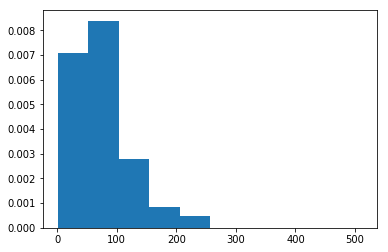

In [5]:
lengths = []
for sent in train_X_filt:
#     print(sent)
    lengths.append(len(sent))
    if max(sent)>50:
        print(sent)
print(np.mean(lengths))
print(np.median(lengths))
print(np.std(lengths))
print(np.max(lengths))
# print(len(lengths>200))
plt.hist(lengths,density=True)

In [6]:
maxlen = 150
# Pad the sentences 
train_X_filt = pad_sequences(train_X_filt, maxlen=maxlen, padding="post")
test_X_filt = pad_sequences(test_X_filt, maxlen=maxlen, padding ="post")


train_X = np.asarray([to_categorical(x, num_classes=vocab_size) for x in train_X_filt])
# test_X_filt = np.asarray([to_categorical(x, num_classes=vocab_size) for x in test_X_filt])


In [7]:
# print(train_X_raw[0])
print(train_X.shape)
print(train_Y.shape)
# print(tokenizer.word_index)

(242429, 150, 27)
(242429,)


In [8]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [9]:
##model definition

model = Sequential()
# model.add(CuDNNLSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Bidirectional(CuDNNLSTM(150, return_sequences=True,), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Flatten())
model.add(Dense(100,activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 150, 300)          214800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               4500100   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 4,715,001
Trainable params: 4,715,001
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])  

In [ ]:
model.fit(train_X, train_Y, epochs=100,batch_size=50,validation_split=0.2)

Train on 193943 samples, validate on 48486 samples
Epoch 1/100
193943/193943 [==============================] - 87s 448us/step - loss: 0.4587 - acc: 0.7832 - f1: 0.6465 - val_loss: 0.3985 - val_acc: 0.8250 - val_f1: 0.6895
Epoch 2/100
193943/193943 [==============================] - 82s 423us/step - loss: 0.3609 - acc: 0.8458 - f1: 0.7539 - val_loss: 0.3539 - val_acc: 0.8486 - val_f1: 0.7285
Epoch 3/100
193943/193943 [==============================] - 83s 426us/step - loss: 0.3114 - acc: 0.8718 - f1: 0.7993 - val_loss: 0.3105 - val_acc: 0.8713 - val_f1: 0.7912
Epoch 4/100
193943/193943 [==============================] - 83s 427us/step - loss: 0.2788 - acc: 0.8867 - f1: 0.8237 - val_loss: 0.2989 - val_acc: 0.8795 - val_f1: 0.8123
Epoch 5/100
193943/193943 [==============================] - 82s 425us/step - loss: 0.2465 - acc: 0.9015 - f1: 0.8473 - val_loss: 0.3113 - val_acc: 0.8761 - val_f1: 0.7953
Epoch 6/100
193943/193943 [==============================] - 83s 427us/step - loss: 0.211

In [18]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten

model=Sequential()
model.add(Conv2D(10,(3,3)))
model.add(Conv2D(10,(3,3)))
model.add(Flatten())
model.add(Dense(20))
model.add(Dense(10))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# model.build()
# model.summary()

In [14]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)

1.9.0
2.2.4


In [63]:
def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [43]:
import string
letter_count = dict(zip(string.ascii_lowercase, [0]*26))

In [45]:
{chr(i+96):i for i in range(1,27)}

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
## Tokenize the sentences
# tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, char_level=True)
# tokenizer.fit_on_texts(list(train_X_raw))

# train_X = tokenizer.texts_to_sequences(train_X_raw)
# test_X = tokenizer.texts_to_sequences(test_X_raw)

# for sent in train_X_raw:
#     s=[]
#     for char in sent.lower():
#         if char in char_dict.keys():
#             s.append(char_dict[char])
#     if s!=[]:
#         train_X_filt.append(s)
#     else:
#         print(sent)

# ## Get the target values
# # train_Y = df_train['target'].values

# test_X_filt = []
# for sent in test_X_raw:
#     s=[]
#     for char in sent.lower():
#         if char in char_dict.keys():
#             s.append(char_dict[char])
#     test_X_filt.append(s)